# Image Segmentation Analysis (Assignment 5)
Author: Giacomo Aru

IMPORTANT!

All the data are not uploaded to Google Drive and therefore are not available on Google Collab and for this notebook. this is due to data space constraints.

As a first step we import all the libraries useful for the study and load all images and associated masks of the dataset into memory.

In [ ]:
import math
from skimage import io, segmentation, color, graph, util
import plotly.express as px
from matplotlib import pyplot as plt
import numpy as np
import pathlib as pth
import os
import timeit
import pandas as pd

DATASET_DIR = pth.Path('../data/weizmann_horse_db')

In [ ]:
def save_images_to_folder(image_list, folder_path, names):
    # Converti il percorso della cartella in un oggetto Path
    folder_path = pth.Path(folder_path)

    # Salvataggio delle immagini nella cartella
    for i, image in enumerate(image_list):
        filename = folder_path / names[i]
        io.imsave(filename, image.astype('uint16'), check_contrast=False)

In [ ]:
if not os.path.isdir(DATASET_DIR): print('Cartella non trovata')
file_names = [img.name for img in (DATASET_DIR / 'horse').iterdir() if img.suffix == '.png']
horses = [io.imread(img) for img in (DATASET_DIR / 'horse').iterdir() if img.suffix == '.png']
masks = [io.imread(img) for img in (DATASET_DIR / 'mask').iterdir() if img.suffix == '.png']
print('Dataset len:', len(horses))

Dataset len: 327


In [ ]:
def plot_images(images, rows, cols, figsize=(10,10)):
    '''
        To easily show n images in a list in a unique plot
    '''
    num_images = len(images)
    total_plots = rows * cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        ax.axis('off')
    for j in range(num_images, total_plots):
        axes[j].axis('off')

    #plt.tight_layout()
    plt.show()

The dataset is divided into images of horses and associated masks, which correspond to a manual semantic segmentation that divides the horse from the rest in the image.

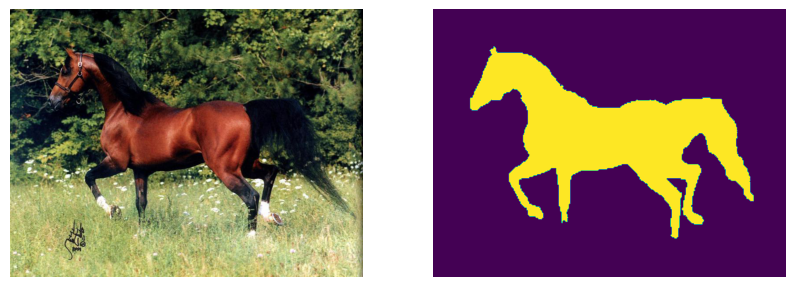

In [ ]:
test_samples = [10, 22, 70, 240, 298, 300]
test_image = horses[70]
test_mask = masks[70]
plot_images([test_image, test_mask], 1, 2, (10,5))

## Preliminary Analysis

One of the main reasons for using superpixel fragmentation first and then applying the NCut algorithm is for efficiency, so first we want to understand what is a good number of subregions into which to divide the space in the first step.

To decide this, we apply the NCut algorithm to several copies of the same image divided into different numbers of superpixels, measure the execution time, and find a good trade-of between efficiency and effectiveness.

We will use the implememntazone of the SLIC segmentation algorithm (based on k-means) provided by scikit-image, as it provides the ability to choose the number of superpixels via a parameter. First let's test some parameters to understand the effect and choose a good combination.

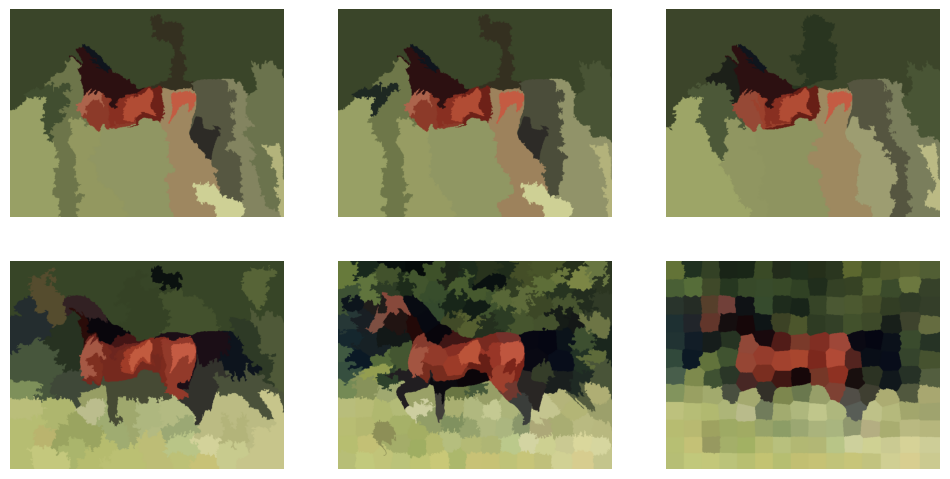

In [ ]:
segments = []
for i in range(-2, 4, 1):
    segments.append(segmentation.slic(test_image, n_segments=180, compactness=(5**i)))
# plot diferent segmentation results varying the compactness parameter
plot_images([color.label2rgb(seg, test_image, kind='avg') for seg in segments], 2, 3, (12,6))

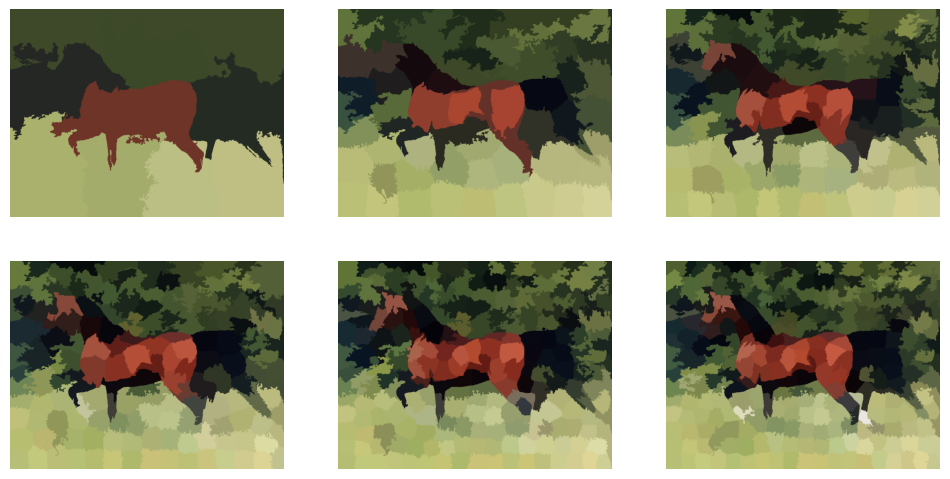

In [ ]:
segments = []
for i in range(10, 300, 50):
    segments.append(segmentation.slic(test_image, n_segments=i, compactness=(5**2)))
# plot diferent segmentation results varying the number of superpixels
plot_images([color.label2rgb(seg, test_image, kind='avg') for seg in segments], 2, 3, (12,6))

A good Compactness value turned out to be 25, now let's run the test mentioned before also taking into account the hoverhead times caused by the creation of the Region Adjacency Graphs.

In [ ]:
execution_times = []

def to_mesure(seg):
    rag = graph.rag_mean_color(test_image, seg, mode='similarity')
    graph.cut_normalized(seg, rag)

n_superpixels_list = list(range(10,1000,50))
for i in n_superpixels_list:
    seg = segmentation.slic(test_image, n_segments=i, compactness=25)
    execution_times.append(timeit.timeit( lambda: to_mesure(seg), number=1))

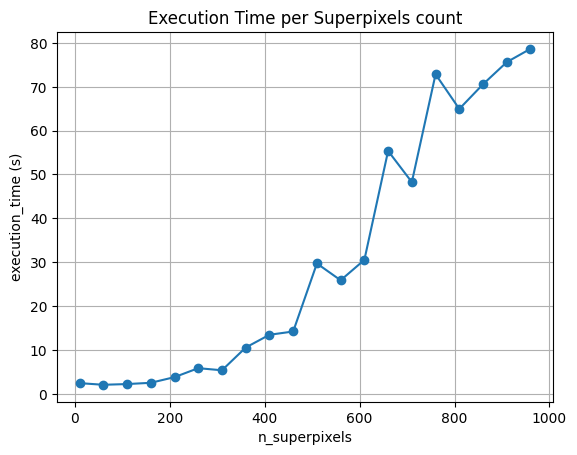

execution times recorded
superpixels	 execution time
10 		 2.4245980999985477
60 		 2.0493271999876015
110 		 2.2134206000046106
160 		 2.5012797999952454
210 		 3.79295099999581
260 		 5.8346007999934955
310 		 5.354825100002927
360 		 10.539904200006276
410 		 13.447885100002168
460 		 14.196227799999178
510 		 29.704240199993365
560 		 25.8705631000048
610 		 30.51634470000863
660 		 55.35732650000136
710 		 48.24552309999126
760 		 72.83735110000998
810 		 64.9334538999974
860 		 70.56333340000128
910 		 75.59944449999603
960 		 78.64437950000865


In [ ]:
plt.plot(n_superpixels_list, execution_times, marker='o')
plt.title('Execution Time per Superpixels count')
plt.xlabel('n_superpixels')
plt.ylabel('execution_time (s)')

plt.grid()
plt.show()
print('execution times recorded')
print('superpixels\t execution time')
for a,b in zip(n_superpixels_list, execution_times):
    print(a, '\t\t', b)

The computational growth begins to increase heavily if we exceed 300 superpixels. From now on we will try to keep the total number of superpixels under 200 per image.

## Superpixel segmentation

The algorithms considered for the first step of segmentation are the following (all the implementations are provided by the skimage library):
1. SLICO: A variant of the classic SLIC (an implementation based on k-means clustering in color-(x,y,z) space) that automatically adjusts the compactness parameter for each superpixel, eliminating the need for manual adjustment. This ensures smoothly shaped superpixels in different regions of the image without sacrificing computational efficiency. In addition, it is often faster and more efficient.
    - [https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic]    
    - [https://www.epfl.ch/labs/ivrl/research/slic-superpixels/#SLICO]
    
2. Quickshift: Segmentation of the image using quickshift clustering in Color-(x,y) space. QuickShift clustering identifies clusters by moving towards high-density regions in the data, without requiring the number of clusters as input.

    - [https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.quickshift]
    
- Felzenszwalb: produce the segmentation of a multichannel image using minimum spanning tree-based clustering on the image grid.

    - [https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb]
    - [https://doi.org/10.1023/B:VISI.0000022288.19776.77]



In this section we analyze their behavior and input parameters in order to achieve a similar and comparable result. Specifically, we will look for the correct combination of parameters to achieve an average number of identified superpixels equal to the one chosen earlier.

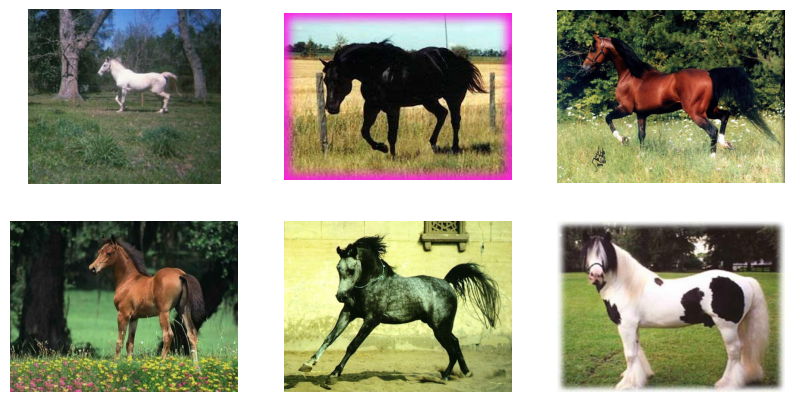

In [ ]:
# reference images
plot_images([horses[h] for h in test_samples], 2, 3, (10,5))

For each algorithm we first visualize the effect of hiperparameters on 6 sample images, chosen because they are diversified and fairly representative of the dataset.

The SLICO algorithm has only one parameter corresponding to the number of superpixels.

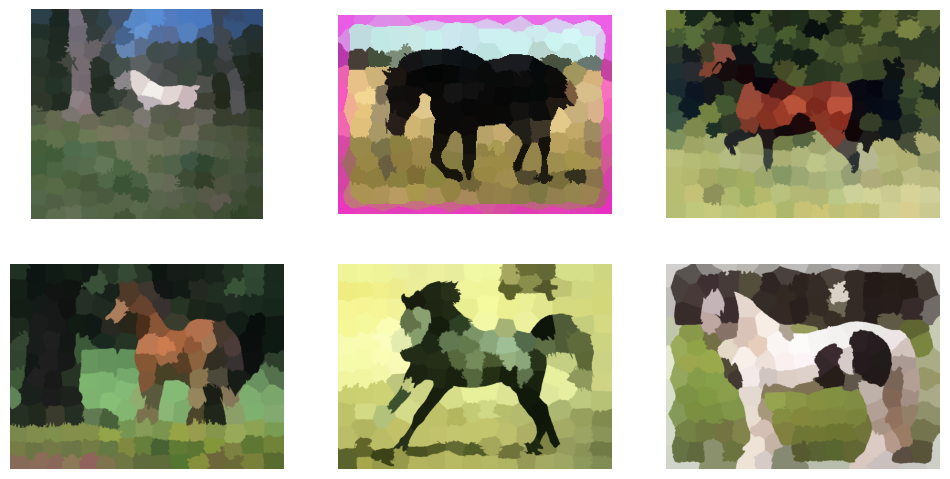

index	 number of superpixel
10 	 182
22 	 192
70 	 180
240 	 179
298 	 177
300 	 172


In [ ]:
# SLICO
segmented_images = [segmentation.slic(horses[index], n_segments=180, slic_zero=True) for index in test_samples]
plot_images([color.label2rgb(segmented_images[i], horses[index], kind='avg') for i, index in enumerate(test_samples)], 2, 3, (12,6))
print('index\t number of superpixel')
for a,b in zip(test_samples, [len(np.unique(x)) for x in segmented_images]):
    print(a, '\t', b)

In [ ]:
segmented_images_1 = [segmentation.slic(horse, n_segments=180, slic_zero=True) for horse in horses]
# execution time: 1m 29s

Next we will study the behavior of quickshift, specifically how to achieve an average number of less then 200 superpixels for each image in the dataset.

The parameters that most affect the number of superpixels are: kernel_size and max_dist that controls rispectively the scale of the local density approximation and the level in the hierarchical segmentation that is produced. The ratio parameter affects the shape of partitions as it balances color-space proximity and image-space proximity.

A careful study [https://doi.org/10.1007/978-3-540-88693-8_52] showed that you have to multiply the two parameters by approximately K if you want to maintain the same number of superpixels in an image whose sides pixels have been multiplied by K.

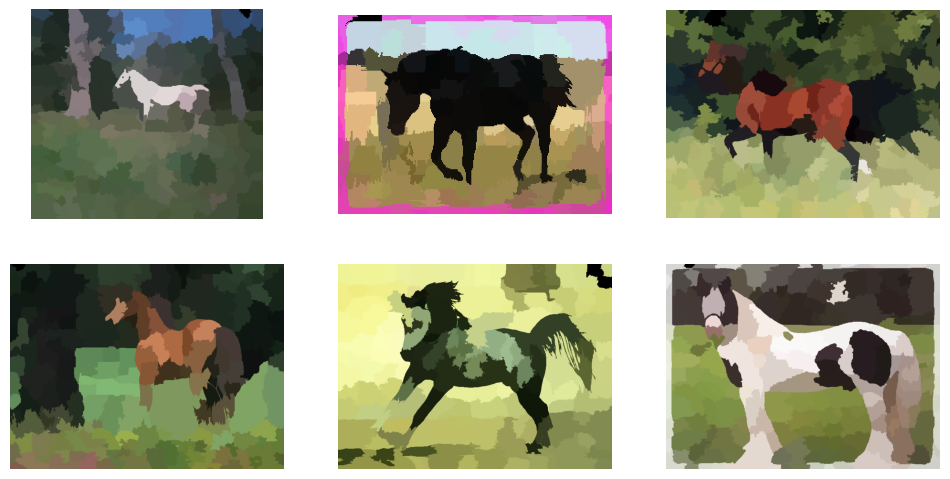

index	 number of superpixel
10 	 175
22 	 161
70 	 188
240 	 157
298 	 143
300 	 177


In [ ]:
# quickshift
segmented_images = []
for index in test_samples:
    lato = math.sqrt(horses[index].shape[0]*horses[index].shape[1])
    modif = lato/300
    segmented_images.append(segmentation.quickshift(horses[index], kernel_size=2.5*modif, max_dist=50*modif, sigma=0.5, ratio=0.8))


plot_images([color.label2rgb(segmented_images[i], horses[index], kind='avg') for i, index in enumerate(test_samples)], 2, 3, (12,6))
print('index\t number of superpixel')
for a,b in zip(test_samples, [len(np.unique(x)) for x in segmented_images]):
    print(a, '\t', b)

In [ ]:
segmented_images_2 = []
for horse in horses:
    lato = math.sqrt(horse.shape[0]*horse.shape[1])
    modif = lato/300
    segmented_images_2.append(segmentation.quickshift(
        horse,
        kernel_size=2.5*modif,
        max_dist=50*modif,
        sigma=0.5,
        ratio=0.8) + 1)  # zero labels are treated weirdly
sp_number_1 = [len(np.unique(i)) for i in segmented_images_2]

# execution time: 19m 16s

In [ ]:
def n_max_indices(lst, n):
    # Enumerate the list to get both value and index
    indexed_list = list(enumerate(lst))

    # Sort the list of tuples by the second element (the values) in descending order
    sorted_list = sorted(indexed_list, key=lambda x: x[1], reverse=True)

    # Extract the indices of the top n items
    top_n_indices = [item[0] for item in sorted_list[:n]]

    return top_n_indices

We were able to get an average of 170 superpixels per image and a rather low variance, below we see the images that were divided with a maximum number of superpixels.

average number of superpixels: 172.6452599388379
variance of number of superpixels: 297.5500004676
index	 number of superpixel
13 	 223
49 	 214
24 	 213
30 	 213
90 	 213
116 	 213


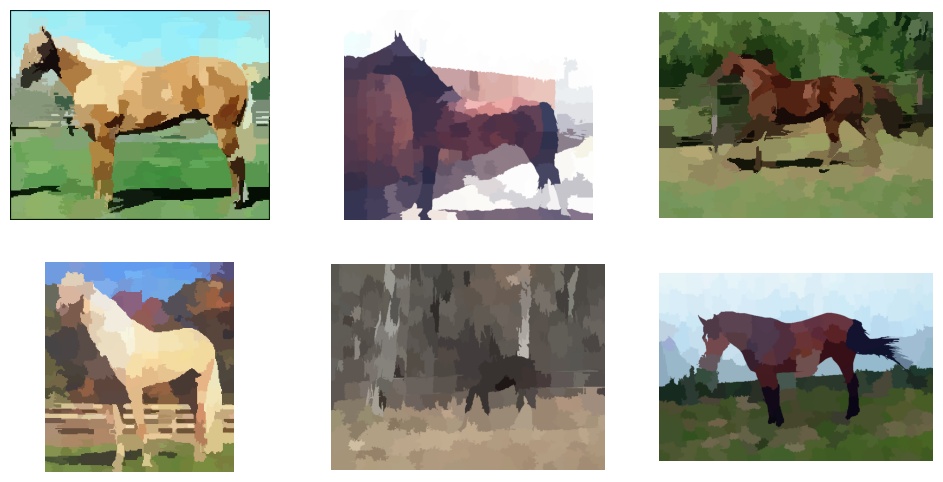

In [ ]:
print('average number of superpixels:', np.mean(sp_number_1))
print('variance of number of superpixels:', np.var(sp_number_1))
print('index\t number of superpixel')
max_sp_1 = n_max_indices(sp_number_1, 6)
for i in max_sp_1:
    print(i, '\t', sp_number_1[i])
plot_images([color.label2rgb(segmented_images_2[index], horses[index], kind='avg') for index in max_sp_1], 2, 3, (12,6))

We conclude this section by studying the felzenszwalb algorith. It produces a segmentation of the image using a fast, minimum spanning tree based clustering on the image grid. The parameter scale sets an observation level. Higher scale means less and larger segments.

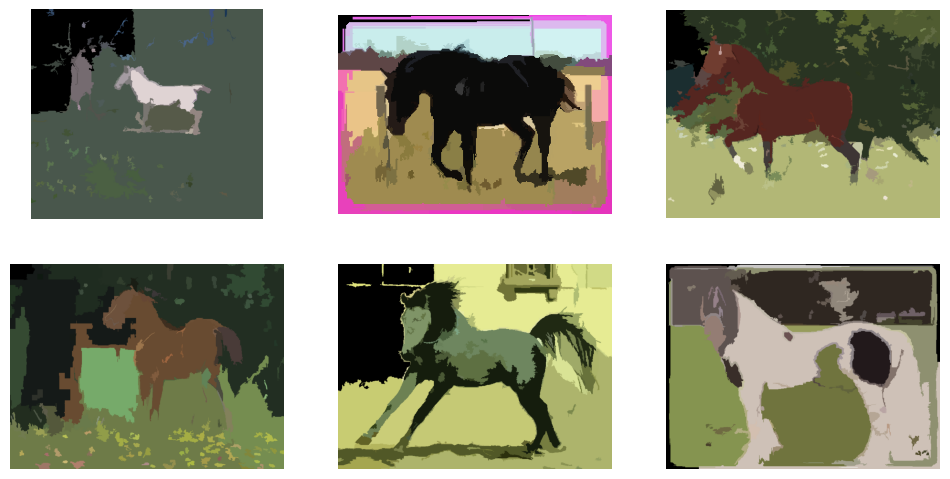

index	 number of superpixel
10 	 77
22 	 133
70 	 162
240 	 133
298 	 152
300 	 81


In [ ]:
# felzenszwalb
segmented_images = []
for index in test_samples:
    lato = math.sqrt(horses[index].shape[0]*horses[index].shape[1])
    modif = lato/300
    segmented_images.append(segmentation.felzenszwalb(horses[index], scale=325*modif, sigma=0.5, min_size=int(40*modif), channel_axis=2))

plot_images([color.label2rgb(segmented_images[i], horses[index], kind='avg') for i, index in enumerate(test_samples)], 2, 3, (12,6))
print('index\t number of superpixel')
for a,b in zip(test_samples, [len(np.unique(x)) for x in segmented_images]):
    print(a, '\t', b)

In [ ]:
segmented_images_3 = []
for horse in horses:
    lato = math.sqrt(horse.shape[0]*horse.shape[1])
    modif = lato/300
    segmented_images_3.append(segmentation.felzenszwalb(horse, scale=325*modif, sigma=0.5, min_size=int(40*modif), channel_axis=2) + 1)  # zeros are treated weirdly
sp_number_2 = [len(np.unique(i)) for i in segmented_images_3]

# execution time: 4m 29s

Empirically we were able to obtain an acceptable result, achieving an average of 130 superpixels and a variance of 1680 (potentially high), we will continue without further studies that would probably improve the result such as scaling the images.

average number of superpixels: 129.52293577981652
variance of number of superpixels: 1683.5889234912884
index	 number of superpixel
268 	 316
305 	 271
50 	 237
152 	 235
35 	 231
150 	 228


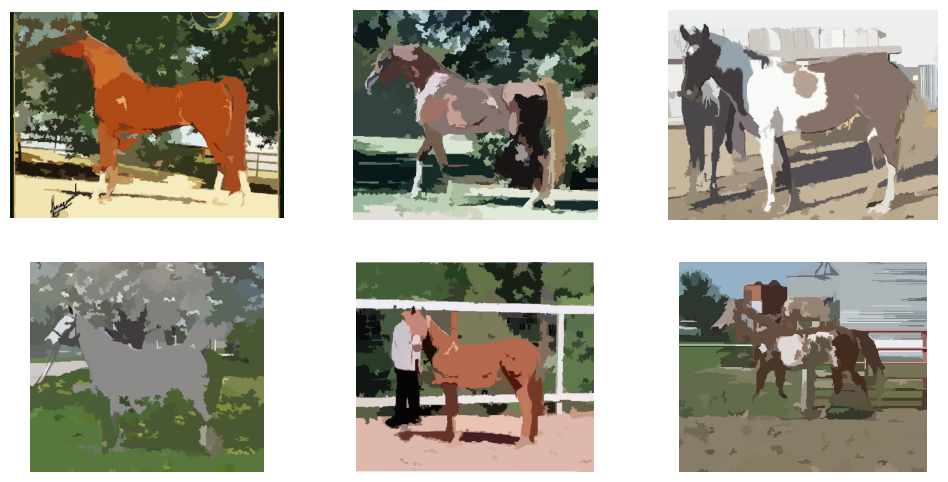

In [ ]:
print('average number of superpixels:', np.mean(sp_number_2))
print('variance of number of superpixels:', np.var(sp_number_2))
print('index\t number of superpixel')
max_sp_2 = n_max_indices(sp_number_2, 6)
for i in max_sp_2:
    print(i, '\t', sp_number_2[i])
plot_images([color.label2rgb(segmented_images_3[index], horses[index], kind='avg') for index in max_sp_2], 2, 3, (12,6))

After observing the 3 algorithms, we immediately notice that the computational time required for segmentation of the entire dataset varies greatly, from a minimum of 1m 30s achieved by SLICO, the most basic algorithm, to a maximum of 19m 16s by quickshift.

Thus, despite the more accurate results of the more complex algorithms, the computation time could be prohibitive in many application fields.

In [ ]:
save_images_to_folder([img.astype('uint16') for img in segmented_images_1], (DATASET_DIR / 'sp_slico'), file_names)
save_images_to_folder([img.astype('uint16') for img in segmented_images_2], (DATASET_DIR / 'sp_quickshift'), file_names)
save_images_to_folder([img.astype('uint16') for img in segmented_images_3], (DATASET_DIR / 'sp_felzenszwalb'), file_names)

## NCut segmentation

In this section we apply the NCut algorithm, using the implementation of the scikit-image library.

In [ ]:
sp_sl = [io.imread(img) for img in (DATASET_DIR / 'sp_slico').iterdir() if img.suffix == '.png']
sp_fel = [io.imread(img) for img in (DATASET_DIR / 'sp_felzenszwalb').iterdir() if img.suffix == '.png']
sp_qck = [io.imread(img) for img in (DATASET_DIR / 'sp_quickshift').iterdir() if img.suffix == '.png']

For each superpixel segmentation algorithm and each image in the dataaset, we apply the NCut to get the final segmentation and save the results.

In [ ]:
sp_segmentations = [sp_sl, sp_qck, sp_fel]
final_segmentation = [[] for i in sp_segmentations]
folder = ['ncut_slico', 'ncut_quickshift', 'ncut_felzenszwalb']
errors = []
for i, horse in enumerate(horses):
    for j, sp in enumerate(sp_segmentations):
        try:
            rag = graph.rag_mean_color(horse, sp[i], mode='similarity')
            final_segmentation[j].append(graph.cut_normalized(sp[i], rag) + 1) # zeros are treated weirdly
        except:
            print('errore: alg:', j, 'img:', i)
            errors.append([i,j])
            final_segmentation[j].append(np.zeros(shape=(horse.shape[0], horse.shape[1]), dtype='uint16'))

# execution time: 30m 50s

errore: alg: 1 img: 15
errore: alg: 2 img: 35
errore: alg: 2 img: 90
errore: alg: 2 img: 95
errore: alg: 2 img: 152
errore: alg: 2 img: 248
errore: alg: 2 img: 268
errore: alg: 2 img: 301
errore: alg: 2 img: 305


Because of a computational specification of the algorithm, not well identified but associated with the computation of eigenvectors needed for the procedure, some segmentations produced by quickshift and felzenszwalb produce errors. We do not study a solution since only a few images generate error and since it would be beyond the scope of the study.

In [ ]:
for i, l in enumerate(final_segmentation):
    save_images_to_folder(l, (DATASET_DIR / folder[i]), file_names)

We now define a measure of accuracy in order to compare the result obtained with segmentation, measuring the overlap between the segments identified by NCut and the ground truth horse semantic segmentation.

The main problem encountered is that the segmentation provided by NCut does not contain semantic information, so it is not possible to distinguish a priori (at least easily) which segment corresponds to the horse, in its entirety or to parts of it. So for this we will rely on the mask itself contained in the dataset.

A first formulated measure calculates the Jaccard distance between the mask and the union of all segments for which at least one pixel falls inside the mask.

A first formulated measure calculates the Jaccard distance between the mask and the union of all the segments for which at least one pixel falls inside the mask. But In this way we penalize too much the situations in which a background segment falls even partially inside the mask, so we opted for a smarter distance for which the horse is the union of all segments whose more than half of the pixels fall inside the mask. This provides a good balance between the various types of errors made by segmentation.

The metric thus obtained is a value ranging from 0 to 1, and for 0 means that the segmentation has no segment reducible to the original horse, 1 that the mask perfectly defines the horse in the segmentation.

In [ ]:
def smart_compare_and_mesure(labels, mask):

    intersection = np.multiply(labels, mask)
    complement = np.multiply(labels, np.logical_not(mask))

    labels_to_merge = np.unique(intersection)
    labels_to_merge = labels_to_merge[labels_to_merge != 0]

    for label in labels_to_merge:
        if sum(intersection[intersection==label]) < sum(complement[complement==label]):
           labels_to_merge = labels_to_merge[labels_to_merge != label]

    mask_2 = np.isin(labels, list(labels_to_merge))

    intersection = np.logical_and(mask, mask_2)
    union = np.logical_or(mask, mask_2)

    return np.sum(intersection) / np.sum(union)

def get_horse_mask(labels, mask):
    intersection = np.multiply(labels, mask)
    complement = np.multiply(labels, np.logical_not(mask))

    labels_to_merge = np.unique(intersection)
    labels_to_merge = labels_to_merge[labels_to_merge != 0]

    for label in labels_to_merge:
        if sum(intersection[intersection==label]) < sum(complement[complement==label]):
           labels_to_merge = labels_to_merge[labels_to_merge != label]

    mask_2 = np.isin(labels, list(labels_to_merge))
    return mask_2


In [ ]:
labels_sl = [io.imread(img) for img in (DATASET_DIR / 'ncut_slico').iterdir() if img.suffix == '.png']
labels_fel = [io.imread(img) for img in (DATASET_DIR / 'ncut_felzenszwalb').iterdir() if img.suffix == '.png']
labels_qck = [io.imread(img) for img in (DATASET_DIR / 'ncut_quickshift').iterdir() if img.suffix == '.png']

Here we calculate the distance mentioned before

In [ ]:
data = {'id':[], 'm_slico':[], 'm_quickshift':[], 'm_felzenszwalb':[]}

for i in range(len(labels_fel)):
    data['id'].append(i)

    data['m_slico'].append(smart_compare_and_mesure(labels_sl[i], masks[i]))
    data['m_felzenszwalb'].append(smart_compare_and_mesure(labels_fel[i], masks[i]))
    data['m_quickshift'].append(smart_compare_and_mesure(labels_qck[i], masks[i]))

evaluations = pd.DataFrame(data)

We exclude errors from the obtained dataframe and display some statistics

In [ ]:
error_quick = [15]
error_fel = [35, 90, 95, 152, 248, 268, 301, 305]
evaluations.loc[error_quick, ['m_quickshift']] = np.nan
evaluations.loc[error_fel, ['m_felzenszwalb']] = np.nan

## Results and final considerations

Through the study of quartiles and maximum and minimum we can understand that:
- all 3 algorithms generated a segmentation in which the measured distance value is 0. This happens when the horse is not divided by the rest of the image into any of its possible components, we can say that therefore the segmentation has failed for all intents and purposes.
- Slico and quickshift have similar distributions, different from the one generated by felzenszwalb, which tends to generate segmentations that get lower scores.
- All 3 algorithms generated at least one nearly perfect segmentation, with a score of about 0.95.

In [ ]:
evaluations.describe()

id     m_slico  m_quickshift  m_felzenszwalb
count  327.000000  327.000000    326.000000      319.000000
mean   163.000000    0.639661      0.631277        0.589162
std     94.540996    0.266745      0.261842        0.298040
min      0.000000    0.000000      0.000000        0.000000
25%     81.500000    0.546714      0.540268        0.409710
50%    163.000000    0.724534      0.699844        0.697140
75%    244.500000    0.832808      0.823711        0.823603
max    326.000000    0.963874      0.946814        0.963863

Here we see the segmentations that generated error to the NCut algorithm

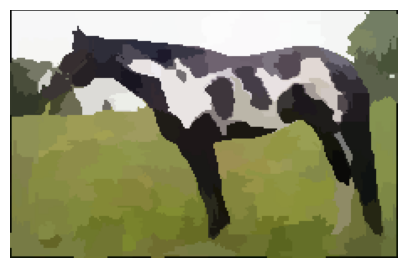

In [ ]:
plot_images([color.label2rgb(sp_qck[index], horses[index], kind='avg') for index in error_quick], 1, 1, (5,4))

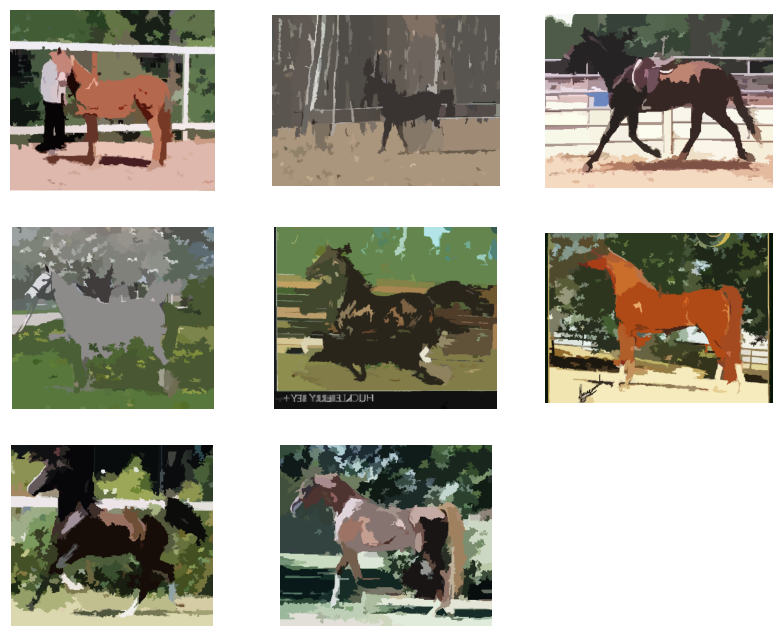

In [ ]:
plot_images([color.label2rgb(sp_fel[index], horses[index], kind='avg') for index in error_fel], 3, 3, (10,8))

Finally, we visualize for each superpixel segmentation algorithm the transformations through which the original image went in order to obtain the final segmentation; in addition, we can compare the mask obtained through the distance metric described earlier and the segmentation generated by NCut and the mask present in the dataset.

We can say, although just looking at the two extremes of the results is not fully explanatory of the dataset, that the metrics used represent the result well. In particular, for values equal to 0 the segmentation generated by NCut completely loses the subject of the image, whereas for values close to 1 the two final masks match almost perfectly.

7 26


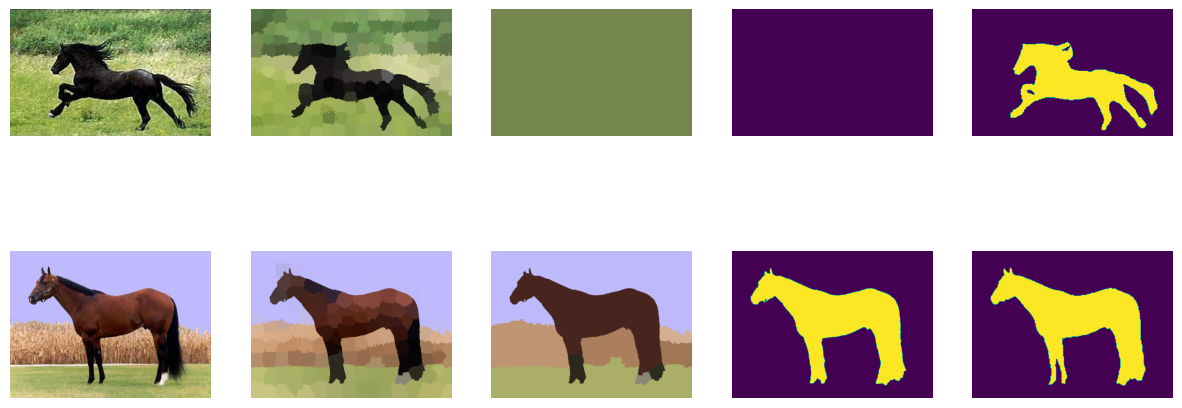

In [ ]:
min_index = evaluations['m_slico'].idxmin()
max_index = evaluations['m_slico'].idxmax()
print(min_index, max_index)
img_to_plot = [horses[min_index],
               color.label2rgb(sp_sl[min_index], horses[min_index], kind='avg'),
               color.label2rgb(labels_sl[min_index], horses[min_index], kind='avg'),
               get_horse_mask(labels_sl[min_index], masks[min_index]),
               masks[min_index],

               horses[max_index],
               color.label2rgb(sp_sl[max_index], horses[max_index], kind='avg'),
               color.label2rgb(labels_sl[max_index], horses[max_index], kind='avg'),
               get_horse_mask(labels_sl[max_index], masks[max_index]),
               masks[max_index]]

plot_images(img_to_plot, 2, 5, (15,6))

25 319


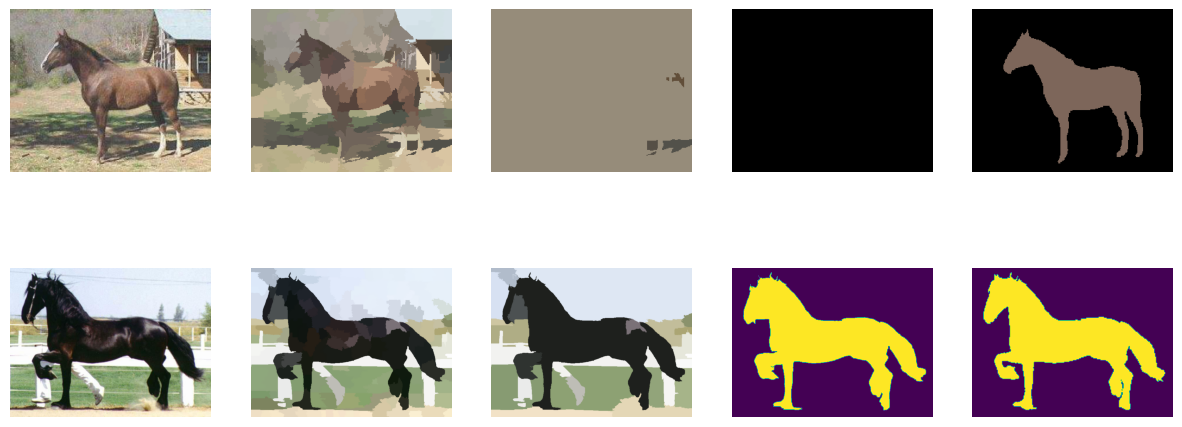

In [ ]:
min_index = evaluations['m_quickshift'].idxmin()
max_index = evaluations['m_quickshift'].idxmax()
print(min_index, max_index)
img_to_plot = [horses[min_index],
               color.label2rgb(sp_qck[min_index], horses[min_index], kind='avg'),
               color.label2rgb(labels_qck[min_index], horses[min_index], kind='avg'),
               color.label2rgb(get_horse_mask(labels_qck[min_index], masks[min_index]), horses[min_index], kind='avg'),
               color.label2rgb(masks[min_index], horses[min_index], kind='avg'),

               horses[max_index],
               color.label2rgb(sp_qck[max_index], horses[max_index], kind='avg'),
               color.label2rgb(labels_qck[max_index], horses[max_index], kind='avg'),
               get_horse_mask(labels_qck[max_index], masks[max_index]),
               masks[max_index]]

plot_images(img_to_plot, 2, 5, (15,6))

311 287


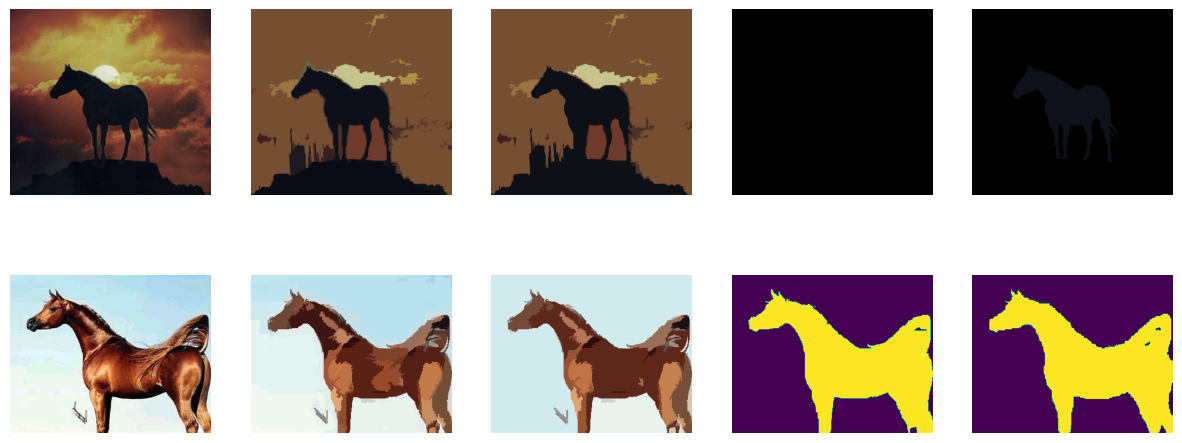

In [ ]:
min_index = evaluations['m_felzenszwalb'].idxmin()
max_index = evaluations['m_felzenszwalb'].idxmax()
print(min_index, max_index)
img_to_plot = [horses[min_index],
               color.label2rgb(sp_fel[min_index], horses[min_index], kind='avg'),
               color.label2rgb(labels_fel[min_index], horses[min_index], kind='avg'),
               color.label2rgb(get_horse_mask(labels_fel[min_index], masks[min_index]), horses[min_index], kind='avg'),
               color.label2rgb(masks[min_index], horses[min_index], kind='avg'),

               horses[max_index],
               color.label2rgb(sp_fel[max_index], horses[max_index], kind='avg'),
               color.label2rgb(labels_fel[max_index], horses[max_index], kind='avg'),
               get_horse_mask(labels_fel[max_index], masks[max_index]),
               masks[max_index]]

plot_images(img_to_plot, 2, 5, (15,6))

Summarizing, we first studied methods to perform superpixel segmentation in images through 3 different algorithms so that the number of superpixels as possible with respect to image features. Then we segmented the entire dataset with the 3 approaches and finally applied NCut to all the segmentations. Through the metrics we created, we evaluated all these final segmentations and exposed the results.

It is clear from this brief study that to perform preliminary fragmentation of superpixels, the more complex methods require way more resources for little or no gain in segmentation effectiveness. Remembering that we did not perform any kind of preprocessing of the data, such as a standardization of the image format, which could have overturned the results.

Taking the combination of SLICO and NCut as a reference, we can say that:
- they turn out to be a very simple technique to apply and time-efficient since it is always possible to reduce the number of superpixels by varying only one parameter and to reduce the segmentation time at the cost of a slight loss in accuracy.
- Despite the diversity of the dataset in content and format of the images, we see that the results are generally positive, and because of the structure of the algorithms, no changes need to be made to them even in cases of apllication to new images, different from those studied.
- It would be interesting to study in detail the influence of the compactness parameter of SLIC to understand whether globular pixels perform better than pixels created by giving more weight to color.
- Segmentations do not always prove to be accurate; in fact, we recorded a case in which the metric created zero-rated a segmentation, in particular, although the division into superpixels divided the monochromatic horse (black) well from the rest of the background (green), the algorithm failed in segmentation, so we would need to understand why.